#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 필요하다고 판단되는 라이브러리를 추가하세요.
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import *

import catboost
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam




In [ ]:
plt.rc('font', family='Malgun Gothic')
sns.set(font="Malgun Gothic",#"NanumGothicCoding",
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [ ]:
data = pd.read_csv('data01_train.csv')
new_data = pd.read_csv('data01_test.csv')

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [ ]:
dynamic_activities = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data['Activity_dynamic'] = data['Activity'].apply(lambda x: 1 if x in dynamic_activities else 0)

In [ ]:
x = data.drop(["Activity","Activity_dynamic"],axis=1)
y1 = data["Activity"]
y2 = data["Activity_dynamic"]

In [ ]:
x1_train, x1_val, y1_train, y1_val = train_test_split(x, y1, test_size=0.2, random_state=1, stratify = y1)
x2_train, x2_val, y2_train, y2_val = train_test_split(x, y2, test_size=0.2, random_state=1, stratify = y2)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 :

In [ ]:
model_rf = RandomForestClassifier()
model_rf.fit(x2_train, y2_train)
y2_pred = model_rf.predict(x2_val)
print('accuracy :',accuracy_score(y2_val, y2_pred))
print(confusion_matrix(y2_val, y2_pred))
print(classification_report(y2_val, y2_pred))

accuracy : 0.9991503823279524
[[646   1]
 [  0 530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



#### 2) 알고리즘2 :

In [ ]:
model_svm = SVC(C=1, gamma=0.0001, kernel = 'linear')
model_svm.fit(x2_train,y2_train)

SVC(C=1, gamma=0.0001, kernel='linear')

In [ ]:
y2_pred = model_svm.predict(x2_val)
print('accuracy :',accuracy_score(y2_val, y2_pred))
print(confusion_matrix(y2_val, y2_pred))
print(classification_report(y2_val, y2_pred))

accuracy : 1.0
[[647   0]
 [  0 530]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       647
           1       1.00      1.00      1.00       530

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177



### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
data2_1 = data[data["Activity_dynamic"]==0]
data2_1 = data2_1.reset_index(drop=True)
x = data2_1.drop(["Activity", "Activity_dynamic"], axis=1)
y = data2_1["Activity"]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 1, stratify = y)

In [ ]:
model_cat_2_1 = CatBoostClassifier(verbose=False)
model_cat_2_1.fit(x_train, y_train, eval_set=(x_val, y_val))
y_pred = model_cat_2_1.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

0.9938176197836167
[[223   0   0]
 [  0 203   3]
 [  0   1 217]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       223
     SITTING       1.00      0.99      0.99       206
    STANDING       0.99      1.00      0.99       218

    accuracy                           0.99       647
   macro avg       0.99      0.99      0.99       647
weighted avg       0.99      0.99      0.99       647



In [ ]:
model_svm2_1 = SVC(C=1, gamma=0.0001, kernel = 'linear')
model_svm2_1.fit(x_train, y_train)
y_pred = model_svm2_1.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

0.9799072642967542
[[223   0   0]
 [  0 200   6]
 [  0   7 211]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       223
     SITTING       0.97      0.97      0.97       206
    STANDING       0.97      0.97      0.97       218

    accuracy                           0.98       647
   macro avg       0.98      0.98      0.98       647
weighted avg       0.98      0.98      0.98       647



### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [ ]:
data2_2 = data[data["Activity_dynamic"]==1]
data2_2 = data2_2.reset_index(drop=True)
x = data2_2.drop(["Activity", "Activity_dynamic"], axis=1)
y = data2_2["Activity"]
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 1, stratify = y)

In [ ]:
model_svm2_2 = SVC(C=1, gamma=0.0001, kernel = 'linear')
model_svm2_2.fit(x_train, y_train)
y_pred = model_svm2_2.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(confusion_matrix(y_val,y_pred))
print(classification_report(y_val,y_pred))

1.0
[[200   0   0]
 [  0 158   0]
 [  0   0 172]]
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       200
WALKING_DOWNSTAIRS       1.00      1.00      1.00       158
  WALKING_UPSTAIRS       1.00      1.00      1.00       172

          accuracy                           1.00       530
         macro avg       1.00      1.00      1.00       530
      weighted avg       1.00      1.00      1.00       530



### [선택사항] (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들어서 분류 모델 합치기

In [ ]:
def classfication(x_test, y_test):
    #정적/동적 행동 분류
    x_test = x_test.reset_index(drop=True)
    y_pred_1 = model_svm.predict(x_test)
    y_pred_1 = pd.DataFrame(y_pred_1, columns=["is_dynamic"])
    data_is_dynamic = pd.concat([x_test, y_pred_1], axis=1)

    #정적 동작 세부 분류
    x_test_2_1 = data_is_dynamic[data_is_dynamic["is_dynamic"]==0]
    x_test_2_1 = x_test_2_1.drop("is_dynamic", axis=1)
    y_pred2_1 = model_cat_2_1.predict(x_test_2_1)
    y_pred2_1 = pd.DataFrame(y_pred2_1, columns=["Activity"], index=x_test_2_1.index)

    #동적 동작 세부 분류
    x_test_2_2 = data_is_dynamic[data_is_dynamic["is_dynamic"]==1]
    x_test_2_2 = x_test_2_2.drop("is_dynamic", axis=1)
    y_pred2_2 = model_svm2_2.predict(x_test_2_2)
    y_pred2_2 = pd.DataFrame(y_pred2_2, columns=["Activity"], index=x_test_2_2.index)
    #print(y_pred2_1)
    #print(y_pred2_2)

    #결과 종합 및 분석
    y_pred = y_pred2_1.combine_first(y_pred2_2)
    #print(y_pred.isnull().sum())
    print('accuracy :', accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, digits=5))
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xticks(rotation=30)
    plt.xlabel('Predicted_y')
    plt.ylabel('Test_y')
    plt.title('Confusion Matrix')
    plt.show()
    return

In [ ]:
target = 'Activity'

x_test = new_data.drop(target, axis=1)
y_test = new_data.loc[:, target]

accuracy : 0.9932019034670292
                    precision    recall  f1-score   support

            LAYING    1.00000   1.00000   1.00000       292
           SITTING    0.99197   0.97244   0.98211       254
          STANDING    0.97603   0.99303   0.98446       287
           WALKING    0.99563   1.00000   0.99781       228
WALKING_DOWNSTAIRS    1.00000   1.00000   1.00000       195
  WALKING_UPSTAIRS    1.00000   0.99535   0.99767       215

          accuracy                        0.99320      1471
         macro avg    0.99394   0.99347   0.99367      1471
      weighted avg    0.99326   0.99320   0.99320      1471



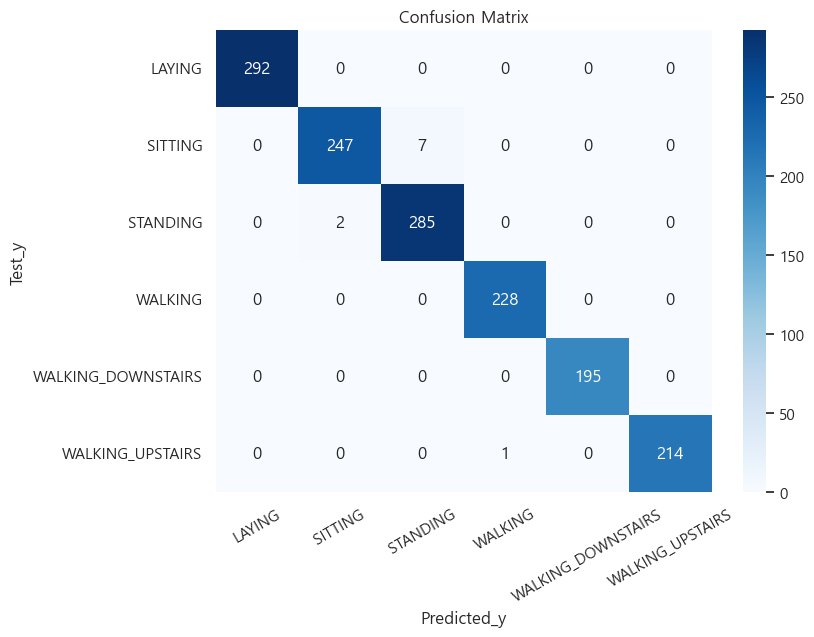

In [ ]:
classfication(x_test, y_test)